# Proyecto 2: Minería de Elementos Frecuentes

- Integrantes de equipo:
  - Martínez Ostoa Néstor Iván
  - Ramírez Bondi Jorge Alejandro
  - Veleros Vega Luis Alfonso
- Materia: Datos Masivos II
- Lic. en Ciencia de Datos, IIMAS, UNAM
- Septiembre 2021

--- 
**Descripción**

El objetivo de este proyecto es implementar el algoritmo **F-P Tree** e identificar los elementos frecuentes y reglas de asociación dentro de un dataset.

**F-P Tree:**
- Frequent Pattern Tree
- Es un árbol de patrones frecuentes basado en la metodología divide y vencerás
- Evita generar conjuntos de elementos candidatos para maximizar el uso de recursos
- Busca comprimir una base de datos hacía un F-P tree


**Datos**

El conjunto de datos se encuentra [aquí](https://www.kaggle.com/irfanasrullah/groceries?select=groceries+-+groceries.csv) y contiene transacciones de compras de supermercado por parte de clientes. Concretamente, contiene 9835 transacciones y 169 productos únicos. 

## Lectura de datos e inicialización de bibliotecas



In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import networkx as nx
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
mounted_in_drive = False
drive_path = "/content/drive/MyDrive/Colab Data/groceries_market_basket.csv"
raw_path = "https://raw.githubusercontent.com/nestorivanmo/iimas-data-science/master/fall-21/massive-data-ii/projects/2-basket-analysis/data.csv"

# Lectura de datos
data_file = drive_path if mounted_in_drive else raw_path
data = pd.read_csv(data_file, dtype='str')


# Breve vista de los datos
print(f"Data shape: {data.shape[0]} transacciones x {data.shape[1]-1} max items por transacción")
data.head()

Data shape: 9835 transacciones x 32 max items por transacción


,Item(s),Item 1,Item 2,Item 3,Item 4,Item 5,Item 6,Item 7,Item 8,Item 9,Item 10,Item 11,Item 12,Item 13,Item 14,Item 15,Item 16,Item 17,Item 18,Item 19,Item 20,Item 21,Item 22,Item 23,Item 24,Item 25,Item 26,Item 27,Item 28,Item 29,Item 30,Item 31,Item 32
0,4,citrus fruit,semi-finished bread,margarine,ready soups,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,tropical fruit,yogurt,coffee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,whole milk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,pip fruit,yogurt,cream cheese,meat spreads,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,other vegetables,whole milk,condensed milk,long life bakery product,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Podemos concluir:**

- La base de datos está conformada por un producto en cada columna.
- La columna `Item(s)` nos permite conocer la cantidad de productos en el registro actual
- La base de datos tiene **9835** transacciones y como máximo **32** items comprados en cada transacción

## Pasos a seguir

Para la construcción del **FP tree** tenemos que seguir los siguientes pasos: 

1. Obtener la lista de items únicos
2. Calcular la frecuencia de cada item
3. Ordenenar los items por frecuencia
4. Seleccionamos únicamente los que cumplan con un soporte mínimo
5. Obtener para cada transacción, el conjunto de items que sean frecuentes
6. Construcción del FP tree a partir de la lista de items frecuentes por cada transacción:
  0. Inicializamos una estructura de datos para un árbol (lista de adyacencia por ejemplo)
  1. Iteramos sobre todas las transacciones
  2. En cada transacción, seleccionamos el primer item frecuente $f_1$
  3. Si $f_1$ está enlistado como un nodo hijo de la raíz:
    1. Incrementamos su frecuencia en $1$
  4. De lo contrario:
    1. Lo agregamos como nodo hijo de la raíz
    2. Inicializamos su frecuencia en $1$
  5. Para todos los items frecuentes de una transacción en particular que no sean el primero, los agregamos como una ruta cuyo padre será el primer item frecuente de esa transacción.


### 1. Obtención de items únicos

Para obtener los items únicos iteramos sobre todos los items presentes en las transacciones. 

In [ ]:
# Obtención de todos los items por transacción
transactions_items = []
for r in data.iterrows():
  row = r[1]
  transactions_items.append(row[~row.isna()].values[1:].tolist())

# Obtención de items únicos en un conjunto
unique_items = set()
bought_items = 0
for transaction in transactions_items:
  for item in transaction:
    unique_items.add(item)
    bought_items += 1

# Transformación a ndarrays
transactions_items = np.array(transactions_items, dtype='object')
unique_items = np.array(list(unique_items))

In [ ]:
print(f"En el dataset se han comprado {bought_items} items de los cuales {unique_items.shape[0]} son únicos\n")
print("Algunos ejemplos:\n----------------")
for idx, u in enumerate(unique_items):
  if idx >= 5: break
  print(f"-{u.capitalize()}")

En el dataset se han comprado 43367 items de los cuales 169 son únicos

Algunos ejemplos:
----------------
-Pudding powder
-Butter
-Specialty chocolate
-Bathroom cleaner
-Liquor (appetizer)


## 2. Cálculo de la frecuencia de cada item

Para hacer esto, necesitamos contar la cantidad que aparece un item en todas las transacciones

In [ ]:
# Conteo por medio de un diccionario
unique_items_freqs = dict()
for transaction in transactions_items:
  for item in transaction:
    if item not in unique_items_freqs:
      unique_items_freqs[item] = 0
    unique_items_freqs[item] += 1

# Creación de un dataframe de frecuencias
freq_items_df = pd.DataFrame({
    "item": unique_items_freqs.keys(),
    "frequency": unique_items_freqs.values()
})
freq_items_df.head()

,item,frequency
0,citrus fruit,814
1,semi-finished bread,174
2,margarine,576
3,ready soups,18
4,tropical fruit,1032


## 3. Ordenamiento de los items por frecuencias

In [ ]:
freq_items_df = freq_items_df.sort_values(by="frequency", ascending=False)
freq_items_df.head()

,item,frequency
7,whole milk,2513
11,other vegetables,1903
17,rolls/buns,1809
31,soda,1715
5,yogurt,1372


A continuación mostramos una distribución de los $k$ items más frecuentes

In [ ]:
def plot_top_k_freq_items(freq_items_df, k):
  df = freq_items_df.iloc[:k, :]
  fig = go.Figure()
  fig.add_trace(go.Bar(
      x=[df.iloc[0,0]], y=[df.iloc[0,1]],
      marker_color="crimson", name=df.iloc[0,0]
  ))
  fig.add_trace(go.Bar(
      x=df.iloc[1:,0], y=df.iloc[1:,1],
      marker_color="lightslategray", name="other items"
  ))
  fig.update_layout(
      template="plotly_white", 
      title=dict(text=f"Frequency distribution of top {k} items")
  )
  fig.show()

In [ ]:
plot_top_k_freq_items(freq_items_df, k=30)

## 4. Filtro de los items que cumplan con un soporte mínimo

El soporte para un item $S_i$ se define como: $$S_i = \frac{f_i}{N}$$ donde $f_i$ es la frecuencia del item $i$ y $N$ es el número total de transacciones

In [ ]:
N = transactions_items.shape[0]
print(f"En el dataset contamos con {N} transacciones")

En el dataset contamos con 9835 transacciones


In [ ]:
# Cálculo del soporte por item
support_per_item = []
for idx, row in freq_items_df.iterrows():
  item_frequency = row["frequency"]
  support = item_frequency / N # <---- soporte
  support_per_item.append(support)


# Dataframe de soportes
support_items_df = pd.DataFrame({
    "item": freq_items_df["item"],
    "frequency": freq_items_df["frequency"],
    "support": support_per_item
})

In [ ]:
support_items_df.head(10)

,item,frequency,support
7,whole milk,2513,0.255516
11,other vegetables,1903,0.193493
17,rolls/buns,1809,0.183935
31,soda,1715,0.174377
5,yogurt,1372,0.139502
24,bottled water,1087,0.110524
42,root vegetables,1072,0.108998
4,tropical fruit,1032,0.104931
52,shopping bags,969,0.098526
50,sausage,924,0.093950


Una vez que tengamos calculado el soporte para cada item, lo que haremos será definir un soporte mínimo para obtener los elementos más frecuentes dentro del dataset.

In [ ]:
# soporte mínimo
min_support = 0.1

# filtro por soporte mínimo
most_frequent_items_df = support_items_df[support_items_df["support"] >= 
                                          min_support]

# elementos más frecuentes
frequent_items = most_frequent_items_df["item"]

In [ ]:
print(f"Para un soporte mínimo de {min_support}, tenemos {frequent_items.shape[0]} items frecuentes")
print(f"Número de transacciones: {N}")
most_frequent_items_df

Para un soporte mínimo de 0.1, tenemos 8 items frecuentes
Número de transacciones: 9835


,item,frequency,support
7,whole milk,2513,0.255516
11,other vegetables,1903,0.193493
17,rolls/buns,1809,0.183935
31,soda,1715,0.174377
5,yogurt,1372,0.139502
24,bottled water,1087,0.110524
42,root vegetables,1072,0.108998
4,tropical fruit,1032,0.104931


## 5. Para cada transacción, obtenemos los items frecuentes

Los items frecuentes se definen como aquellos items cuyo soporte es mayor o igual al soporte mínimo previamente definido.

In [ ]:
# Elementos frecuentes
frequent_items = set(most_frequent_items_df["item"].values)

# Elementos frecuentes por transacción
freq_items_per_transaction = []
transactions_with_freq_items = []

for transaction in transactions_items:
  transaction = set(transaction)
  common_items = frequent_items.intersection(transaction)
  if len(common_items) > 0:
    freq_items_per_transaction.append(list(common_items))
    transactions_with_freq_items.append(list(transaction))

# Dataframe con los datos finales
final_df = pd.DataFrame({
    "items": transactions_with_freq_items,
    "frequent_items": freq_items_per_transaction
})

In [ ]:
print(f"Elementos más frecuentes:")
print(most_frequent_items_df)

print("\n------------------------")
print(f"Número de transacciones totales: {N}")
print(f"Número de transacciones con elementos frecuentes: {final_df.shape[0]}")
print(f"Proporción del {round(final_df.shape[0]/N, 2)*100}%")
print("------------------------")


final_df.head()

Elementos más frecuentes:
                item  frequency   support
7         whole milk       2513  0.255516
11  other vegetables       1903  0.193493
17        rolls/buns       1809  0.183935
31              soda       1715  0.174377
5             yogurt       1372  0.139502
24     bottled water       1087  0.110524
42   root vegetables       1072  0.108998
4     tropical fruit       1032  0.104931

------------------------
Número de transacciones totales: 9835
Número de transacciones con elementos frecuentes: 6668
Proporción del 68.0%
------------------------


,items,frequent_items
0,"[yogurt, coffee, tropical fruit]","[yogurt, tropical fruit]"
1,[whole milk],[whole milk]
2,"[pip fruit, yogurt, meat spreads, cream cheese]",[yogurt]
3,"[other vegetables, whole milk, long life baker...","[other vegetables, whole milk]"
4,"[butter, yogurt, abrasive cleaner, whole milk,...","[whole milk, yogurt]"


**Generamos un conjunto de prueba.**

In [ ]:
test_df = pd.DataFrame({
    'frequent_items': [
      ['f', 'c', 'a', 'm', 'p'],
      ['f','c','a','b','m'],
      ['f','b'],
      ['c','b','p'],
      ['f','c','a','m','p']
    ]
})
test_tree = tree(test_df)

## 6. Construcción del FP tree

In [ ]:
class node:
  def __init__(self, item, frequency, parent, id):
    self.item = item
    self.frequency = frequency
    self.parent = parent
    self.children = []
    self.id = id
  
  def increment_frequency(self, increment=1):
    self.frequency += increment
  
  def add_children(self, node):
    self.children.append(node)
  
  def item_in_children(self, item):
    """Verificamos si un elemento está en los nodos hijos."""
    for child in self.children:
      if child.item == item:
        return child
    return False


class tree:
  def __init__(self, df):
    self.num_nodes = 0
    self.root = node('', None, None, self.num_nodes)
    self.df = df
    self.create_tree()
  
  def create_tree(self):
    for transaction in self.df.frequent_items:
      current_node = self.root
      for item in transaction:
        if not self.root.children:
          self.num_nodes += 1
          n = node(item, 0, self.root, self.num_nodes)
          self.root.add_children(n)
          
        child = current_node.item_in_children(item)
        if child:
          child.increment_frequency()
        else:
          self.num_nodes += 1
          child = node(item, 1, current_node, self.num_nodes)
          current_node.add_children(child)
        current_node = child

# 7. Visualización del F-P Tree

In [ ]:
def create_nx_graph(tree):
  # Creación de la gráfica mediante NetworkX
  g = nx.Graph()
  g.add_nodes_from([(tree.root.id, {'item': tree.root.item, 
                            'frequency': tree.root.frequency})])
  to_visit = tree.root.children.copy()
  while to_visit:
    n = to_visit.pop(0)
    g.add_nodes_from([(n.id, {'item': n.item, 
                        'frequency': n.frequency})])
    g.add_edge(n.id, n.parent.id)
    to_visit.extend(n.children) # Utilizamos extend para evitar anidamiento
  return g


def draw_tree(g, node_size=1000, font_size=12, figsize=(10, 10)):
  labels = nx.get_node_attributes(g, 'item')
  labels = dict(g.nodes.data())
  graph_labels = dict()
  for l in labels:
    label_str = f"{labels[l]['item']}:{labels[l]['frequency']}"
    graph_labels[l] = label_str
  fig = plt.figure(figsize=figsize)
  nx.draw_networkx(g, labels=graph_labels, ax=fig.add_subplot(111), 
                  font_color='#001e38', node_color='#d5d9e0', 
                   node_size=node_size, font_size=font_size)
  return fig

**Visualizamos con el conjunto de prueba.**

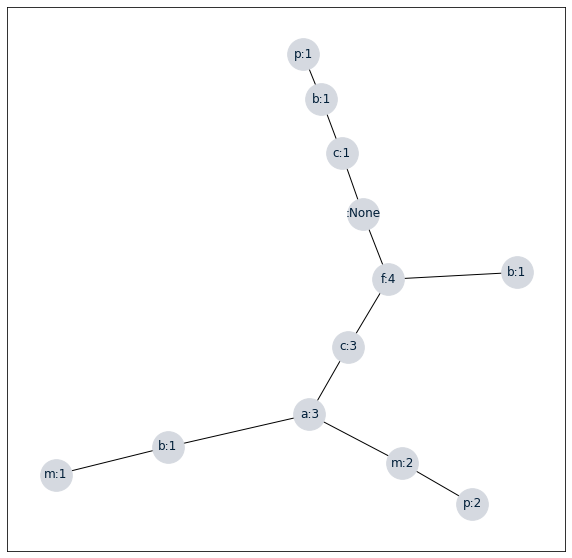

In [ ]:
g_test = create_nx_graph(test_tree)
fig = draw_tree(g_test)
# fig.savefig("g.pdf")

**Utilizamos la base de datos completa.**

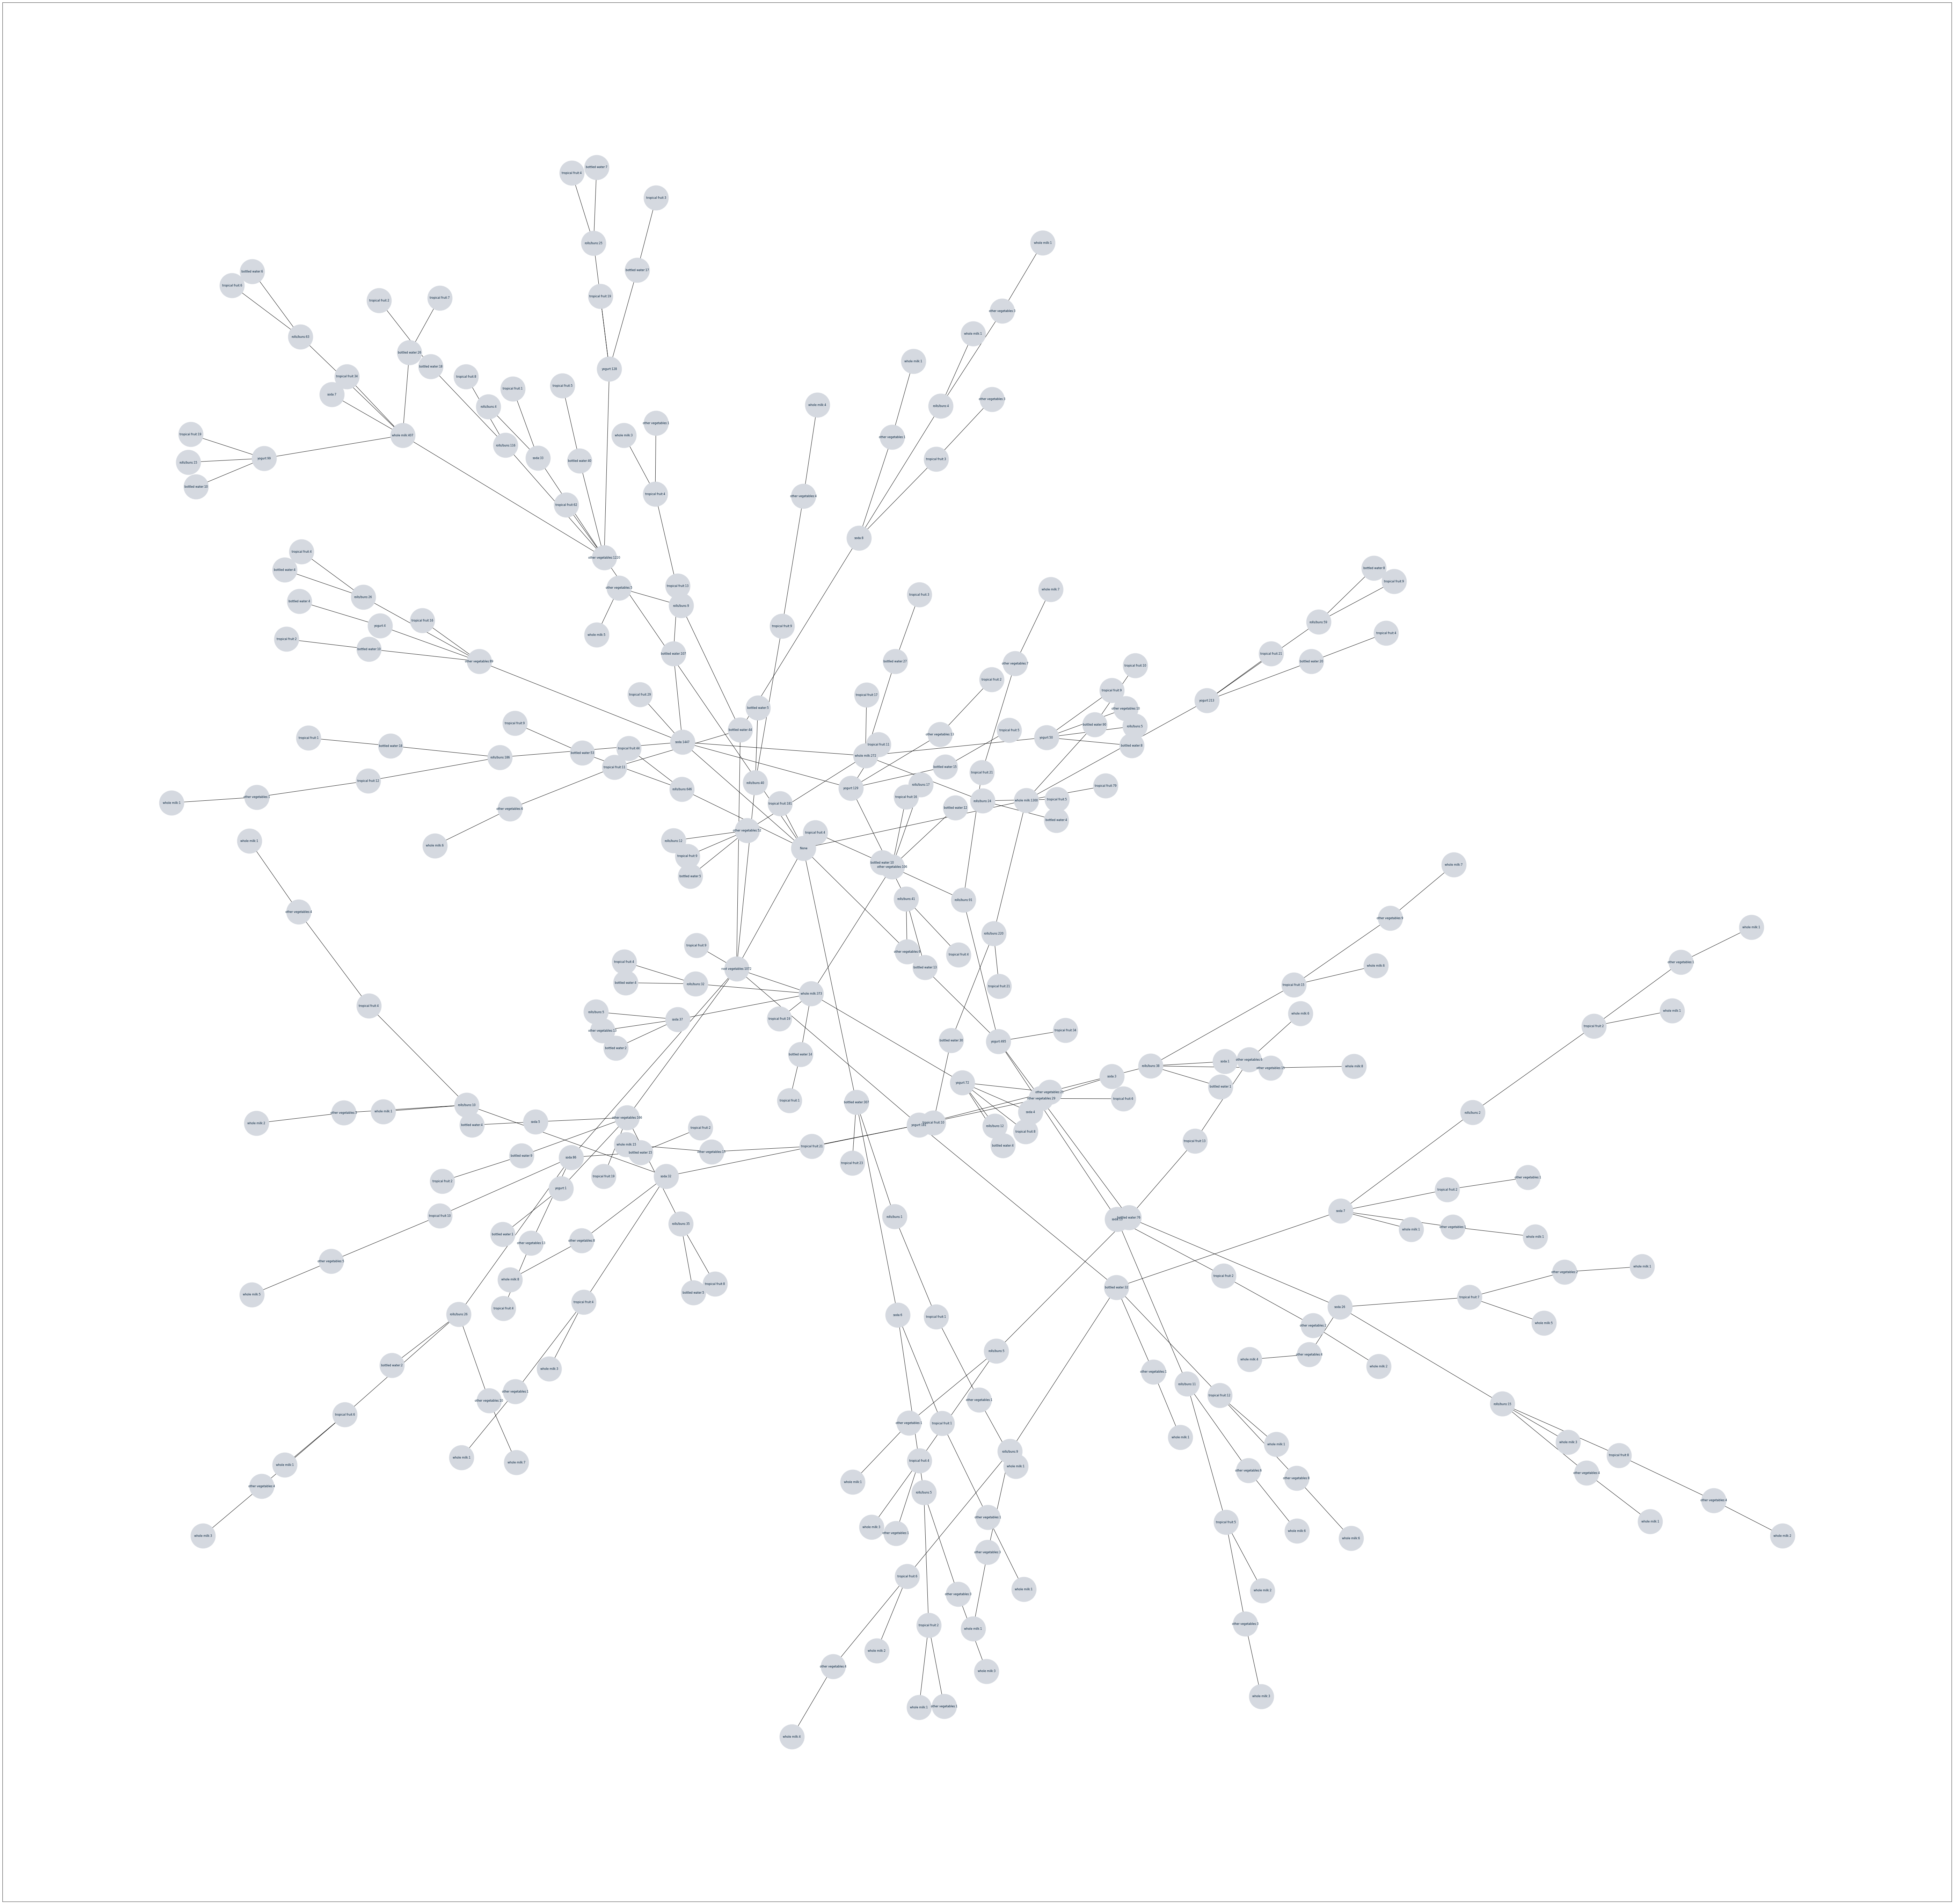

In [ ]:
figsize = (100, 100)
data_tree = tree(final_df)
g_data = create_nx_graph(data_tree)
fig = draw_tree(g_data, node_size=5000, font_size=8, figsize=figsize)
plt.savefig("final.pdf")